### **RQ3:** Quais padrões (tags) estão associados a sentimentos negativos/positivos?

In [16]:
from google.colab import drive
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
analyzed_path = '/content/drive/My Drive/comp-soc/analyzed.jsonl'
results = defaultdict(lambda: {'pos': 0, 'neg': 0})

In [10]:
def contar_sentimento_por_tag(tags, sentimento, campo_nome):
    if pd.isna(sentimento) or not isinstance(tags, list):
        return
    for tag in tags:
        if sentimento == 1:
            continue
        field = 'pos' if sentimento == 2 else 'neg'
        results[(tag, campo_nome)][field] += 1

In [12]:
for chunk in pd.read_json(analyzed_path, lines=True, chunksize=1000):
    for _, row in chunk.iterrows():
        tags = row.get("tags", [])

        # Sentimento do corpo da pergunta
        contar_sentimento_por_tag(tags, row.get("body_sentiment"), "body")

        # Sentimentos das respostas
        answers = row.get("answers", [])
        if isinstance(answers, list):
            for answer in answers:
                contar_sentimento_por_tag(tags, answer.get("body_sentiment"), "body_answer")

            # Comentários da resposta
            comments = answer.get("comments", [])
            if isinstance(comments, list):
                for comment in comments:
                    contar_sentimento_por_tag(tags, comment.get("text_sentiment"), "comments_answer")

        # Sentimentos dos comentários da pergunta
        comments = row.get("comments", [])
        if isinstance(comments, list):
            for comment in comments:
                contar_sentimento_por_tag(tags, comment.get("text_sentiment"), "comments")

In [35]:
df = pd.DataFrame([{'tag': tag, 'campo': campo, 'positivos': valores['pos'], 'negativos': valores['neg']} for (tag, campo), valores in results.items()])
df.head()

,tag,campo,positivos,negativos
0,java,body,13720,11355
1,java,comments_answer,23373,8785
2,java,comments,16726,17099
3,javascript,comments_answer,40442,13115
4,dc.js,comments_answer,65,18


#### Tags com maior proporção de sentimento positivo e negativo
Consideramos apenas as tags associadas a mais de 1000 posts, pois as mais raras tendem a bater 100% de proporção em algum lado. Para medir a proporção, dividimos pelo número total de posts (positivos + negativos)

In [169]:
def plot_top_sentimentos_abs(df, top_n=20):
    df_agrupado = df.groupby('tag')[['positivos', 'negativos']].sum().reset_index()
    top_positivos = df_agrupado.nlargest(top_n, 'positivos')
    top_negativos = df_agrupado.nlargest(top_n, 'negativos')

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

    sns.barplot(data=top_positivos, x='positivos', y='tag', hue='tag', ax=axes[0], palette='crest', legend=False)
    axes[0].set_title('Top 20 Tags com mais Sentimentos Positivos')
    axes[0].set_xlabel('Quantidade de positivos')
    axes[0].set_ylabel('Tag')
    axes[0].set_xlim(0, 110000)

    sns.barplot(data=top_negativos, x='negativos', y='tag', hue='tag', ax=axes[1], palette='flare', legend=False)
    axes[1].set_title("Top 20 Tags com mais Sentimentos Negativos")
    axes[1].set_xlabel("Quantidade de Negativos")
    axes[1].set_ylabel("Tag")
    axes[1].set_xlim(0, 110000)

    plt.tight_layout()
    plt.show()

def plot_top_sentimentos_normalizado(df, top_n=20):
    df_agrupado = df.groupby("tag")[["positivos", "negativos"]].sum().reset_index()

    df_agrupado['qtd_posts'] = df_agrupado['positivos'] + df_agrupado['negativos']
    df_agrupado = df_agrupado.loc[df_agrupado['qtd_posts'] >= 1000]
    df_agrupado['positivos_norm'] = df_agrupado['positivos'] / df_agrupado['qtd_posts']
    df_agrupado['negativos_norm'] = df_agrupado['negativos'] / df_agrupado['qtd_posts']

    top_positivos = df_agrupado.nlargest(top_n, "positivos_norm")
    top_negativos = df_agrupado.nlargest(top_n, "negativos_norm")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

    sns.barplot(data=top_positivos, x="positivos_norm", y="tag", hue='tag', ax=axes[0], palette='crest', legend=False)
    axes[0].set_title("Top 20 Tags com mais Sentimentos Positivos")
    axes[0].set_xlabel("Proporção de Positivos")
    axes[0].set_ylabel("Tag")
    axes[0].set_xlim(0, 1)

    sns.barplot(data=top_negativos, x="negativos_norm", y="tag", hue='tag', ax=axes[1], palette='flare', legend=False)
    axes[1].set_title("Top 20 Tags com mais Sentimentos Negativos")
    axes[1].set_xlabel("Proporção de Negativos")
    axes[1].set_ylabel("Tag")
    axes[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

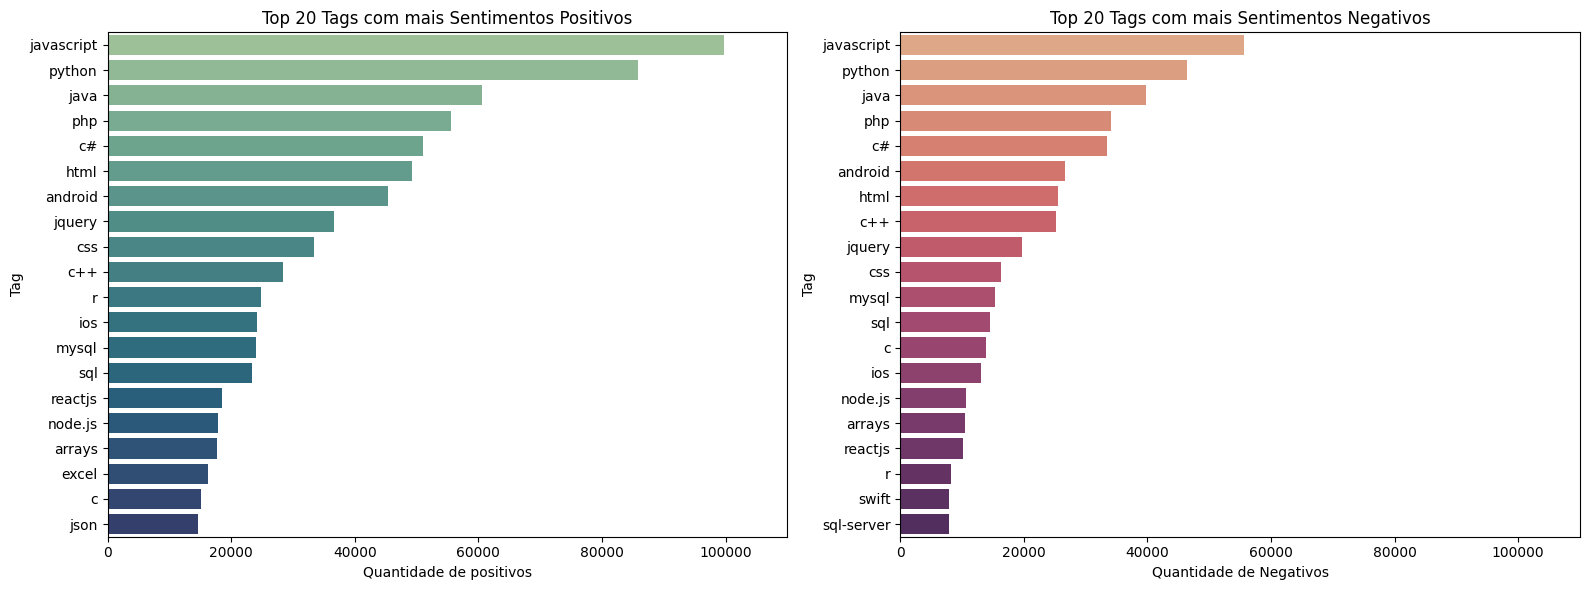

In [167]:
plot_top_sentimentos_abs(df)

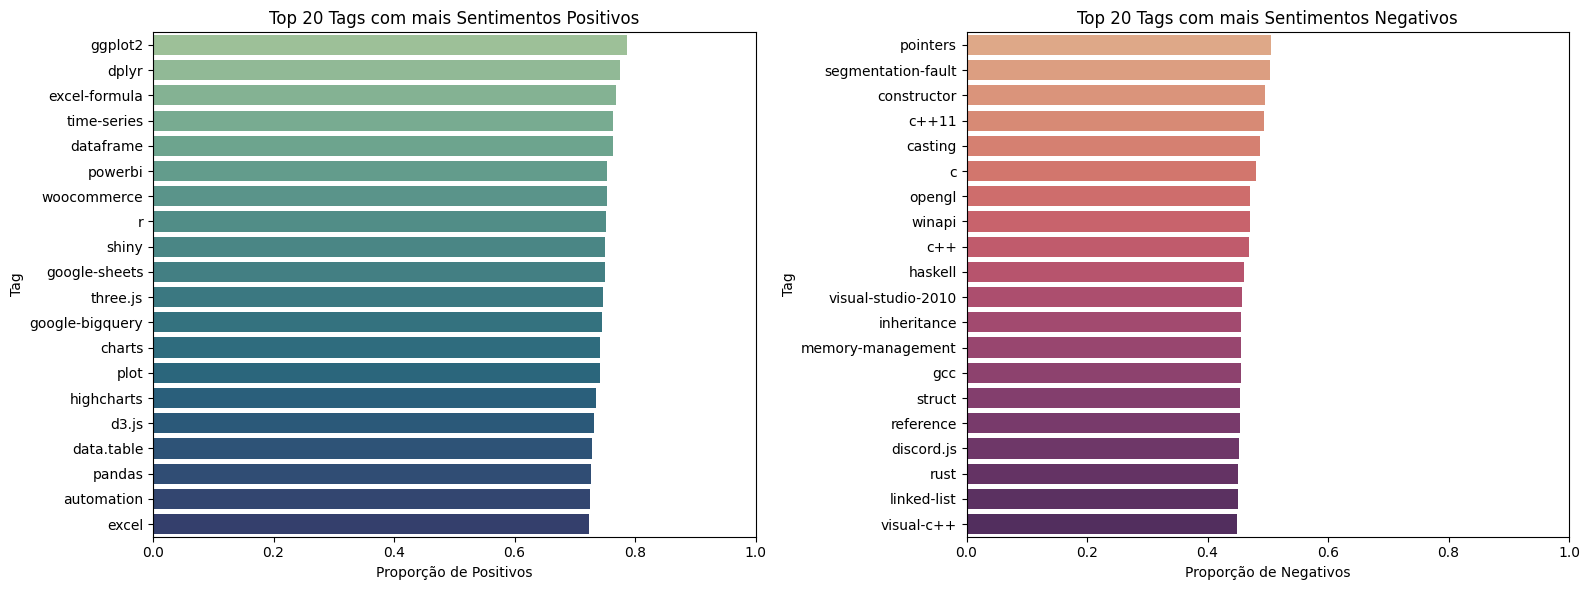

In [170]:
plot_top_sentimentos_normalizado(df)

#### Avaliando o saldo de positivos e negativos
Avaliamos a diferença proporcional entre posts positivos e negativos associados às tags. Para manter a coerência com a análise anterior, também normalizamos pela quantidade e pegamos apenas tags associadas a mais de 1000 posts

In [164]:
def plot_saldo_sentimento(df, topn=10):
    df_agrupado = df.groupby('tag')[['positivos', 'negativos']].sum().reset_index()
    df_agrupado['qtd_posts'] = df_agrupado['positivos'] + df_agrupado['negativos']
    df_agrupado = df_agrupado.loc[df_agrupado['qtd_posts'] >= 1000]
    df_agrupado['saldo'] = (df_agrupado['positivos'] - df_agrupado['negativos']) / df_agrupado['qtd_posts']

    top_positivas = df_agrupado.nlargest(topn, "saldo")
    top_negativas = df_agrupado.nsmallest(topn, "saldo")

    df_plot = pd.concat([top_positivas, top_negativas])
    df_plot = df_plot.sort_values("saldo")

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x="saldo", y="tag", hue='tag', palette="icefire", legend=False)
    plt.title(f"Saldo do sentimento por tag")
    plt.xlabel("Saldo de Sentimento (positivos - negativos)")
    plt.ylabel("Tag")
    plt.axvline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

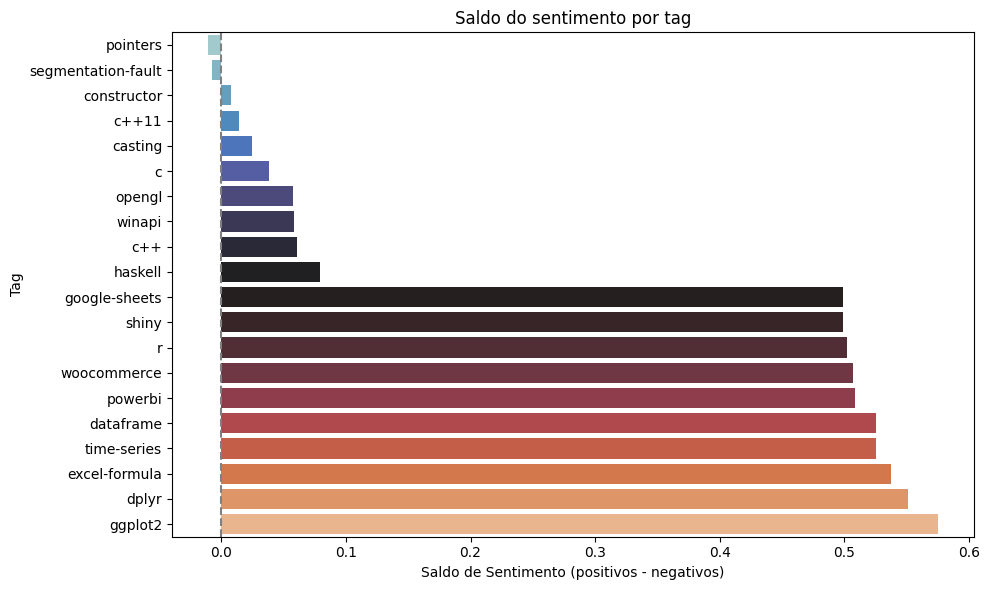

In [165]:
plot_saldo_sentimento(df)

#### Analisando os melhores resultados
Agora, uma análise mais aprofundada nas tags com sentimento mais intenso. Vamos fazer um heatmap para as tags e a sua positividade/negatividade em cada um dos campos de texto. Isso será feito pela proporção.

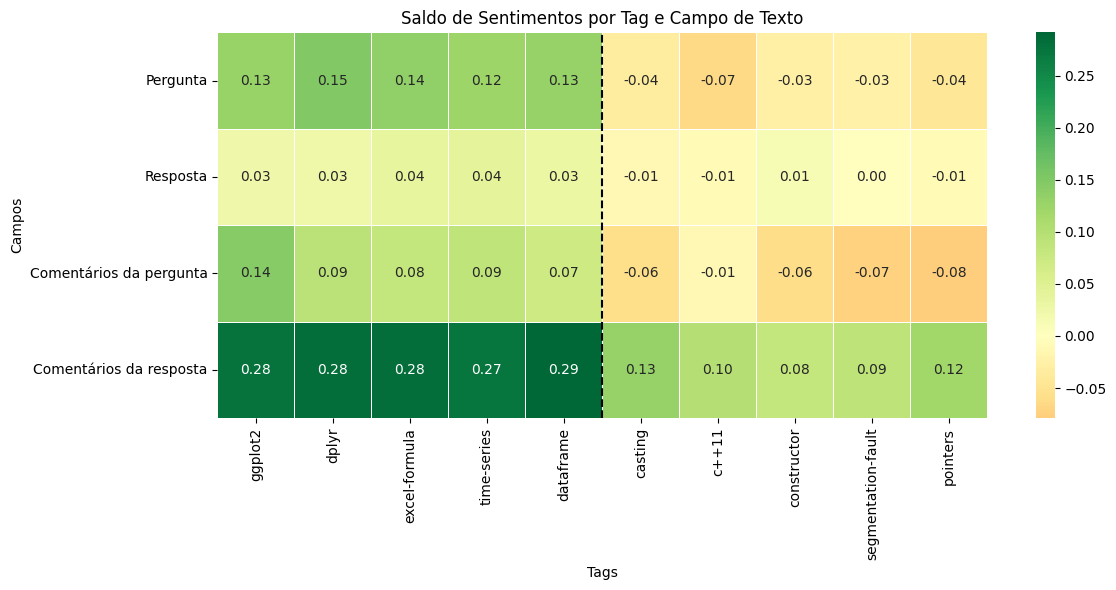

In [186]:
tags_positivas = ['ggplot2', 'dplyr', 'excel-formula', 'time-series', 'dataframe']
tags_negativas = ['casting', 'c++11', 'constructor', 'segmentation-fault', 'pointers']
tags_alvo = tags_positivas + tags_negativas

campos = ['body', 'body_answer', 'comments', 'comments_answer']
label_map = {
    "body": "Pergunta",
    "body_answer": "Resposta",
    "comments": "Comentários da pergunta",
    "comments_answer": "Comentários da resposta"
}

heatmap_data = []

df_agrupado = df.groupby('tag')[['positivos', 'negativos']].sum().reset_index()
df_agrupado['qtd_posts'] = df_agrupado['positivos'] + df_agrupado['negativos']


for campo in campos:
    linha = []
    for tag in tags_alvo:
        df_filtro = df[(df['campo'] == campo) & (df['tag'] == tag)]
        pos = df_filtro['positivos'].values[0]
        neg = df_filtro['negativos'].values[0]
        total = df_agrupado[df_agrupado['tag'] == tag]['qtd_posts'].iloc[0]
        saldo_norm = ((pos - neg) / total) # normalizando o saldo pelo tamanho do conjunto
        linha.append(saldo_norm)
    heatmap_data.append(linha)

# Criar DataFrame para o heatmap
df_heatmap = pd.DataFrame(heatmap_data, index=[label_map[c] for c in campos], columns=tags_alvo)

# Plot do heatmap
plt.figure(figsize=(12, 6))
ax = sns.heatmap(df_heatmap, annot=True, cmap='RdYlGn', center=0, linewidths=0.5, fmt=".2f")
ax.axvline(x=5, color='black', linestyle='--', linewidth=1.5)

plt.title("Saldo de Sentimentos por Tag e Campo de Texto")
plt.xlabel("Tags")
plt.ylabel("Campos")
plt.tight_layout()
plt.show()

#### Análise qualitativa
Verificando a negatividade dos posts com pointers

In [191]:
# CÓDIGO GERADO PELO GEMINI!

# Lista para armazenar os textos negativos encontrados
negative_posts_with_pointers = []
limit = 20

print("Buscando por posts negativos com a tag 'pointers'...\n")

try:
    # Lendo o arquivo em chunks para não sobrecarregar a memória
    for chunk in pd.read_json(analyzed_path, lines=True, chunksize=500):
        if len(negative_posts_with_pointers) >= limit:
            break

        for _, row in chunk.iterrows():
            if len(negative_posts_with_pointers) >= limit:
                break

            tags = row.get("tags", [])
            # Verifica se 'pointers' está na lista de tags
            if 'pointers' in tags:
                # Checa o sentimento do corpo da pergunta
                # O sentimento negativo é representado por 0
                if row.get("body_sentiment") == 0:
                    post_info = {
                        "type": "Pergunta",
                        "text": row.get("body")
                    }
                    if post_info not in negative_posts_with_pointers:
                      negative_posts_with_pointers.append(post_info)

                # Checa o sentimento das respostas
                answers = row.get("answers", [])
                if isinstance(answers, list):
                    for answer in answers:
                        if len(negative_posts_with_pointers) >= limit:
                            break
                        if answer.get("body_sentiment") == 0:
                            post_info = {
                                "type": "Resposta",
                                "text": answer.get("body")
                            }
                            if post_info not in negative_posts_with_pointers:
                                negative_posts_with_pointers.append(post_info)

    # Imprime os resultados encontrados
    if negative_posts_with_pointers:
        print(f"--- Encontrados {len(negative_posts_with_pointers)} exemplos de conteúdo negativo com a tag 'pointers' ---\n")
        for i, post in enumerate(negative_posts_with_pointers, 1):
            print(f"--- Exemplo {i} ({post['type']}) ---")
            print(post['text'])
            print("\n" + "="*50 + "\n")
    else:
        print("Nenhum post ou resposta negativa com a tag 'pointers' foi encontrado.")

except FileNotFoundError:
    print(f"Erro: O arquivo '{analyzed_path}' não foi encontrado. Verifique o caminho.")
except Exception as e:
    print(f"Ocorreu um erro ao processar o arquivo: {e}")

Buscando por posts negativos com a tag 'pointers'...

--- Encontrados 20 exemplos de conteúdo negativo com a tag 'pointers' ---

--- Exemplo 1 (Pergunta) ---
Can anyone explain me why this is true: I know it has something to do with lvalue and rvalue but shouldn't be a rvalue? edit: sorry it seems I confused myself and others, I asked this while reading "this MDSN" http and I was surprised to see this syntax, I see it's a special feature that allows to convert lvalue into lvalue as long as it's the same size.


--- Exemplo 2 (Resposta) ---
Why do you think your cast is legal? I'm getting on both casts. This shouldn't be legal. If you really want to do it, you have to cast it like this: But don't do that unless you know what you are doing.


--- Exemplo 3 (Pergunta) ---
I was studying in depth about pointers as I don't think I have good knowledge about pointers and came across the following line on Wikipedia: When dealing with arrays, the critical lookup operation typically
  involves a